# MSDS Marketing Text Analytics, Unit 2 Lab 1: Segmenting by sales rank

## ⚡️ Make a Copy

Save a copy of this notebook in your Google Drive before continuing. Be sure to edit your own copy, not the original notebook.

## 🔬 How to complete this lab

### Follow along

This is a hands-on lab. Step through the notebook, read and understand the content, and execute the code cells. Be sure you understand each step along the way -- don't just execute the cells and move on without understanding what happened.


### Do the work

There are some DIY portions in this notebook. You will need to complete these portions in order to complete the lab. Provided you have followed along with understanding, these should be straightforward tasks to complete.


### Answer the questions.

There are questions along the way that you are meant to answer. These will verify that you have followed along and will check your understanding. **Your answers to these questions should be transferred to the Quiz in Coursera** in order to receive credit for the lab.

## Introduction

Not all Amazon products in a product category are the same. Some products are purchased a lot, others are not. The purpose here is to leverage the metadata in the Amazon product entries and pull out products that sell a lot.

To do this you will iterate through both the product and review data. First you will inspect the product metadata to find top product ASINS, then you'll go through the review data to pull the matching reviews for those ASINS.

## **⚡️ Preparation:** Get the data files

Before starting you will need to copy the following data files up to your Google Drive account. These files are available in the course resources in Coursera:

[Amazon reviews and product metadata files](https://www.coursera.org/learn/unsupervised-text-classification-for-marketing-analytics/resources/kNX7Q)

## Mount Google Drive

After uploading the files to your Google Drive, mount Drive in order to allow Colab to access the files.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## Imports

In [1]:
import gzip
import json

In [2]:
import itertools

## Inspecting the data

### The JSON-L data format

If you look directly in the data file, you will find that it is in a format of one product-per line. Each product is a json data structure. This is an unofficial data format commonly referred to as JSON-L (the -L meaning per-line).

⚠️ **Data format differs from the source data:** Unlike the reviews data, which was originally distributed in json-l format, the metadata is distributed as lines of python code that need to be evaluated. We have done this evaluation for you and re-formatted the data file. The file available in the course assets is in the re-formatted json-l.

### The product data structure

Looking at the individual lines, you would find a product data structure like the following example Nike product that has been formatted for easier reading:

```
{
    "asin": "B00APTJF6G",
    "related": {
        "also_bought": [ "B003JK5Y8G", "B00B2V1EEW" ],
        "also_viewed": [
            "B003JK5Y8G", "B00CB3259I", "B008QYSBRQ", "B00B2V1EEW", "B00E0WL76U",
            "B00CHQTGL4", "B00KQQ6HDW", "B008EMDAB2", "B008IBB2V4", "B00E0WKOAA",
            "B0052H0M9K", "B00HUXPAI2", "B00K5YT3KO", "B00CUQZYHG", "B00J8V3PDG",
            "B00APTKB5K", "B001GUSWJ4", "B00CM0COS2", "B00J2JODHQ", "B00E0NOFUO",
            "B00IDCBLXC", "B009IUDL0O", "B00JG6J2IA", "B00JJ6RCCK", "B008K6OIIG",
            "B00KHYBFPI", "B009O5KX7M", "B00GS1X0CK", "B00K0TM84M", "B00BYCCJSE",
            "B00DGCXOES", "B00DRMMYFW", "B00IURRG02", "B007T8HL9O", "B00FL837DI",
            "B006JRPQN4", "B008EMBHSA", "B00E3G4V02", "B004N6UVPG", "B00DU5UV60",
            "B00J8UU6MU", "B00EEC7OI6", "B00EDW2MG6", "B00IK609JI", "B008IB8TOM",
            "B00GN9V66Y", "B00KPZ6DSS", "B00HLMTTFM", "B00EJT1CEG", "B00DRL3EBQ",
            "B00IURWBTI", "B00GS1X1BU" ],
        "bought_together": [ "B003JK5Y8G", "B00B2V1EEW", "B00E9ZATJO" ]
    },
    "title": "Nike Womens Free TR Fit 3 Running Shoes",
    "price": 88.78,
    "salesRank": {
        "Shoes": 73520
    },
    "imUrl": "http://ecx.images-amazon.com/images/I/41ZGSvJDi%2BL._SX395_.jpg",
    "brand": "Nike",
    "categories": [
        [
            "Clothing, Shoes & Jewelry",
            "N",
            "Nike"
        ],
        [
            "Clothing, Shoes & Jewelry",
            "Women",
            "Shoes",
            "Athletic",
            "Running"
        ]
    ]
}
```

### Some things to note:

1. This product has been set to have the brand "Nike". However, if you dig into the raw data, you will see that not all products have a brand associated with them. For this reason, we will be using the brand names embedded in the category data to segment this data by brand.

2. The category data is a list of lists. We will need to either flatten this data, or iterate it (we show you both!) in order to find the brand name in the categories.

3. salesRank is provided as a key-value pair in the format of category:rank. This is the sales rank of the product within that product category, where a lower number is a better ranking.

## 👟 Discovering the Nike ASINs


Since not all products have a brand value set, we will extract ASINs for products with "Nike" in the categories. We will ignore the title case of instances of Nike to be sure we catch things like NIKE and nike.

💡 **On brands and ambiguity:** Nike is an unambiguous brand name, so we can be reasonably sure of our results. Given a more general name that might show up in the category data, you would probably have to work a little harder at digging out the ASINs for this data.

### Build a list of Nike ASINs

The following code to build a list of Nike ASINs has been completed for you. Read through the code, execute it, and be sure you understand how it works. Consider also reading the optional tips below for variations on how this code could be handled.

In [3]:
asins = []

# !!!
# To run this code, you will need to have downloaded the metadata file from the
# course assets and upload it to your Google Drive. See the notes about that file
# regarding how it was processed from the original file into json-l format.

with gzip.open("meta_Clothing_Shoes_and_Jewelry.jsonl.gz") as products:
    for product in products:
        data = json.loads(product)
        categories = []
        for category_list in data.get("categories", []):
            _catlist = []
            for item in category_list:
                _catlist.append(item.lower())
            categories += _catlist
        if "nike" in categories:
            asins.append(data["asin"])

The length of `asins` will tell us how many we have:

In [4]:
len(asins)

8327

Inspect a few to see that things look as expected:

In [5]:
asins[:3]

['B0000V9K32', 'B0000V9K3W', 'B0000V9K46']

---

## 🧐 Lab Quiz Question #1

What is the number of Nike ASINs extracted from the product metadata? Enter this number as your answer to Question #1 in Coursera.

---

---

### 🐍 **Optional:** Simplify things with a list comprehension

Take a closer look at this code from above:

```
       for category_list in data.get("categories", []):
            _catlist = []
            for item in category_list:
                _catlist.append(item.lower())
            categories += _catlist
```

We had to do this nested iteration in order to normalize the categories to lowercase format. However, there is an opportunity to use a list comprehension here to clean things up a bit and make it all a bit more "Pythonic". The resulting code might look like this:

```
       for category_list in data.get("categories", []):
            _catlist = [ item.lower() for item in category_list ]
            categories += _catlist
```

In fact, you could take it a step further and replace that entire block with a nested comprehension ... but at some point it is important to think about the tradeoffs between cleverness and readability.

Another way to flatten the list rather than iterating it would be to make use of the handy itertools module.

---

### 🐍 **Optional:** Use itertools to flatten the list

The [itertools module](https://docs.python.org/3/library/itertools.html) provides some handy convenience tools for dealing with various iterable things. Here is what the above code might look like using itertools to flatten the categories:

```
    for product in products:
        data = json.loads(product)
        categories = itertools.chain(*data.get("categories", []))
        categories = [c.lower() for c in categories]
```

Keep `itertools` in mind when you are working with iterable data sets.

---

## 🔁 Recap so far

So far, we have taken a look at the data to get a sense of the data structure. We have seen that:

 - Product metadata is in JSON-L format with one json-encoded product per line of the file.
 - Products are identified by an ASIN value keyed as "asin"
 - Some products have a "brand" key, but not all.
 - Products have a "categories" structure which is a list of lists. The brand can be found among the categories even when there is no "brand" key on the data.

We have then used this information to extract a list of ASINs for the products of a specific brand.

## Thinking about segmentation

You should have extracted something over 8000 ASINs above, all having "Nike" as a category.

> 💡 **Hint:** The exact number of Nike ASINs is the answer to Quiz question #1!


When doing an analysis like this, you will often not want to look at everything all at once. For this reason, you might segment the data in various ways. It is important to think ahead and to strategize a bit when considering segmentation.

> 🤔 **Food for thought:** Looking at the data, what are some ways you might consider segmenting for useful analysis? Here we use a simple data point in the data. In an upcoming assignment, you will use natural language process (NLP) methods to segment the data according to the language of the text entered by the reviewers.

Here, you will implement a very straightforward and common kind of segmentation for sales related data. You will take advantage of the "salesRank" information on the products, and build a list of just the top selling Nike products.

## 📈 Taking a look at sales rank

Looking at the data above product example again, recall that there is a "salesRank" key which gives us the product's categorical rank in the format:

```
    { category: rank }
```

We are interested in extracting this rank data in order to produce a data structure of sales ranks by ASIN.

> **Coding Task:** Below, you will do the work of building a dictionary structure of `ASIN:SalesRank` key-value pairs. The code will be much like the code above to create a list of ASINs, but along the way, you will extract the sales rank and include that information in the data structure.

The sales rank is a bit unusual as a dictionary structure in that it is just a single key-value pair. We want to extract this information from the products where it exists, and do so in a way that will not break where it does not. One algorithm for doing this would be:


 - Check that "salesRank" both exists **and** contains information. E.g.:

    ```{"Shoes": 73520}```

 - Convert the `.items()` of the sales rank dictionary into a list for indexing. E.g.:

    ```[("Shoes", 73520)]```

 - Take the 0-index item of the list, which is a (category, rank) tuple. E.g.:

    ```("Shoes", 73520)```

 - Take the 1-index item of that tuple, which is the rank. E.g.:

    ```73520```






## 🔨 Do the work

The code cell below looks a lot like the ASINs extraction code that you executed above. But this code will not execute as-is!

Your job is to complete the last part of this code to populate the `sales_ranks` dictionary with product sales ranks keyed by ASIN.

The resulting data structure will have the following format:

```
    {
        'B0000V9K32': 67039,
        'B0000V9K3W': 102054,
        'B0000V9K46': 116131

        ... (etc.)

    }
```

Correctly implemented, your resulting sales_rank dictionary should have 7962 elements.

> 💡 **Pro tip:** Jumping straight into the code below could get frustrating really quickly. You could find your self looping and re-looping 8000+ products in a draining excercize of troubleshoot-and-wait iterations.

> When you have a big task like this, consider how to make it smaller in order to make the development easier. A simple thing here would be just to work with a small section of the data. Consider this code snippet for one approach:

```
with open(somefile) as f:
    count = 0
    for i, line in enumerate(f):
        if i > 10:
            break
        ...
```

We have included similar break code in a commented section of the code below. If you make use of this break, just be sure to take it back out to run all the products in the end. Your final sales_rank data should have 7962 items.

In [6]:
sales_ranks = {}

with gzip.open("meta_Clothing_Shoes_and_Jewelry.jsonl.gz") as products:
    for i, product in enumerate(products):
        #Uncomment these lines to reduce the debug cycle for troubleshooting only !!!
        #if i > 10000: # 10000 because we don't hit Nike products for a while
        #    break
        data = json.loads(product)
        categories = []
        for category_list in data.get("categories", []):
            _catlist = []
            for item in category_list:
                if item.strip() != item:
                    print(category_list)
                _catlist.append(item.lower())
            categories += _catlist
        if "nike" in categories:
            if data.get("salesRank"):
                # TODO: Complete the extraction of sales rank and populate
                # that information into the sales_ranks dictionary, keyed
                # by the asin value.
                sales_rank = data["salesRank"]
                if sales_rank:
                    rank = list(sales_rank.items())[0][1]
                    sales_ranks[data["asin"]] = rank

Check the length of `sales_rank`

In [7]:
len(sales_ranks)

7962

Inspect the first few items of `sales_rank`

In [8]:
dict(list(sales_ranks.items())[:3])

{'B0000V9K32': 67039, 'B0000V9K3W': 102054, 'B0000V9K46': 116131}

## 🧐 Lab Quiz Questions #2 and #3

**Q2:** What is the best ranking Nike product ASIN for which we have sales rank data? Recall that smaller ranking values are better.

**Q3:** What is its rank?

Use the following code snippet to answer these questions:

In [9]:
import operator
ordered_asin_ranks = sorted(sales_ranks.items(), key=operator.itemgetter(1))
ordered_asin_ranks[0]

('B00EQBFL62', 179)

### 🐍 Python Tip

See the [Python sorting how-to](https://docs.python.org/3/howto/sorting.html#sortinghowto) for more information about advanced sortings like the one above.

## 📊 Plot a histogram

You have now gathered all the product ranking data. For analysis, however, we really just want to look at the top ranking products. How many products, you ask? A histogram will help us to make that decision.

### 🐍 The Seaborn library

[Seaborn](https://seaborn.pydata.org/) is a statistical data visualization library that makes quick work of some common types of visualizations. Here we see that it makes histogram plotting almost trivial.

The histogram (a.k.a. [distplot](https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn.displot) with `kind` set to "hist", the default) in seaborn simply takes a list of values. In this case, we want to plot the sales ranks, which is just the values list of the sale_ranks dictionary:

C:\Users\Dennis\AppData\Local\Temp\ipykernel_4972\3565203646.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plot = sns.distplot(list(sales_ranks.values()))


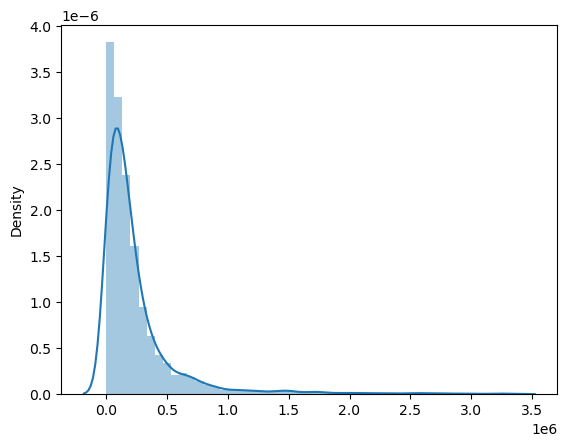

In [10]:
import seaborn as sns
plot = sns.distplot(list(sales_ranks.values()))

You can see here that there is quite a long tail of low-ranking products, i.e. large values going to the right on the x-axis. Some of these rankings are low enough that Seaborn has plotted at a scale of 1 x 10^6. It looks like our lowest ranking product ranks as about the 3.5 millionth best selling product in it's category!

We can verify this simply by looking at the last item of the ordered list we produced above:

In [11]:
ordered_asin_ranks[-1]

('B000AYI6FC', 3341111)

At a glance, we can see that the bulk of our ranked products, however, fall into the range of 0 to 3000, where 3000 is indicated as 0.5 x 1x10^6.

For purposes of analysis, then, let's create a filtered subset of the list that contains only ASINs of products with a sales rank of 3000 or better.

In [12]:
best_asins = [asin for asin, rank in sales_ranks.items() if rank <= 3000]

### Inspect a few items:

In [13]:
best_asins[:3]

['B0001LGWEQ', 'B000G42Z2Q', 'B000RDFRIK']

### Check the length

In [14]:
len(best_asins)

274

## Finalizing your data prep

This lab has been all about segmenting products by sales rank, and a lot of that work is now done. But, in the end, we don't just want the list of products ... we want the product reviews so that we can discover interesting things such as what are customers saying about the best selling products.

Now that you've prepared a set of ASINs of products worth analyzing, you will do the work of collecting their reviews. Recall that the reviews are contained in the second JSON-L data file.

## 🔨 Do the work

The code block below sets you up to iterate the review data.

In order to collect the reviews into a useful data structure, we will create a concept of a key that is made up of the asin.reviewerID. Constructing this ID might look something like this, given `review` as the data structure of a single review:

```
review_id = "%s.%s" % (review["asin"], review["reviewerID"]
```

To complete the code block below, do the work of collecting the reviews of the top ASINs (remember our best_asins list above) keyed by the special ID for the review, e.g.:

```
top_reviews[review_id] = review
```

In [16]:
top_reviews = {}

with gzip.open("reviews_Clothing_Shoes_and_Jewelry_5.json.gz") as reviews:
    for i, review in enumerate(reviews):
        review = json.loads(review)
        # REMEMBER to remove this break once you have things working!!!
        if i > 50000: # it takes a while to hit any Nike products in the data
            break

        _id = "%s.%s" % (review["asin"], review["reviewerID"])

        # TODO: if the asin is in best_asins, add the review to top_reviews
        #       keyed by the newly constructed _id
        if review["asin"] in best_asins:
            top_reviews[_id] = review
            

### Check the length of the resulting review set

In [17]:
len(top_reviews)

52

---

## 🧐 Lab Quiz Question #4

How many Nike product reviews are there for products that rank in the top 3000 of their sales category?

Use the length of `top_reviews` to answer this question.

---



## 📓 Lab summary

In this lab, we tackled some aggregation, extraction, and segmentation tasks typically associated with the pre-processing phase of a data analytics job.

A few things we discovered along the way:

 * Sales data can be tricky to deal with, and may not be consistent even when coming from the same source.
 * Directly inspecting the data is often necessary, and we should not assume that data entries will be consistently contstructed, and consistency can be impacted by the chosen data distribution format.


In a coming assignment, you will revisit the idea of segmentation by NLP techniques to extract only reviews with negative sentiment.



## Save top reviews as a JSON-Lines file for use in Lab 3.

In an upcoming module, you will complete a lab where you will use deep learning techniques to produce a topic model of the top product reviews. Execute the following code to save those reviews to a JSON-L file for use in that lab.

In [18]:
with open("MSDS_Lab1_TopReviews.jsonl", "w") as top_reviews_file:
    for k, v in top_reviews.items():
        review = json.dumps(v)
        top_reviews_file.write(f"{review}\n")